# Предсказание стоимости недвижимости в Москве
### ==========================Импорт Библиотек==========================

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler

# выбранная модель
from sklearn.ensemble import GradientBoostingRegressor

# Дата для работоспосбности кода в 2020+
from datetime import datetime

# Метрика
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold

# Magic commands
%matplotlib inline 
# вывод графики в ноутбук
%config InlineBackend.figure_format = 'svg' 
# более четкое отображение, формат фала фигуры svg

### ==========================Исходные Датасеты==========================

In [2]:
df_train = pd.read_csv('import/train.csv') # загружаем тренировочный датасет в датафрейм df_train
df_test = pd.read_csv('import/test.csv') # загружаем тестовый датасет в датафрейм df_test

#TRAIN_DATASET_PATH = './realestatepriceprediction/train.csv'
#TEST_DATASET_PATH = './realestatepriceprediction/test.csv'
#df_train = pd.read_csv(TRAIN_DATASET_PATH) # загружаем тренировочный датасет в датафрейм df_train
#df_test = pd.read_csv(TEST_DATASET_PATH) # загружаем тестовый датасет в датафрейм df_test

In [3]:
df_train.dtypes # Типы признаков

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [3]:
# Превратим ID и DistrictId в строку, так как по сути это название района.
df_train['Id'] = df_train['Id'].astype(str) 
df_train['DistrictId'] = df_train['DistrictId'].astype(str)
df_test['Id'] = df_test['Id'].astype(str) 
df_test['DistrictId'] = df_test['DistrictId'].astype(str)

### ==========================EDA(exploratory data analysis)==========================

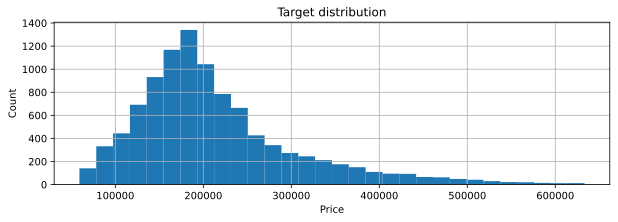

In [14]:
# Обзор целевой переменной

plt.figure(figsize = (10, 3))

df_train['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

нет нулевых значений. 

In [15]:
df_train.describe() # Обзор всех числовых признаков

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [16]:
df_train.select_dtypes(include='object').columns.tolist() # Категориальные признаки

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

### ==========================Обработка данных==========================

In [4]:
class Cleaner():
    district_reach = []
    
    def __init__(self):
        #self.med_price_by_district = None
        print(type(self))

    
    def transform(self, X):
        
        # Добавляю признак неадекватности комнат
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        

        # заменяю неадекватное кол-во комнат на 1,2,3,4 в зависимости от площади
        missing_rooms_data = X.loc[ (X['Rooms'] ==0) | (X['Rooms'] > 6), ['Square', 'Rooms']]
        if missing_rooms_data['Square'].count() !=0:
            for i in missing_rooms_data.index:
                if (missing_rooms_data.loc[(i),'Square']) < 43:
                    (missing_rooms_data.loc[(i),'Rooms']) = 1
                elif (missing_rooms_data.loc[(i),'Square']) < 60:
                    (missing_rooms_data.loc[(i),'Rooms']) = 2
                elif (missing_rooms_data.loc[(i),'Square']) < 100:
                    (missing_rooms_data.loc[(i),'Rooms']) = 3
                elif (missing_rooms_data.loc[(i),'Square']) > 100:
                    (missing_rooms_data.loc[(i),'Rooms']) = 4
            X.loc[ (X['Rooms'] ==0) | (X['Rooms'] > 6), 'Rooms'] = missing_rooms_data['Rooms']
        
        # Делаем выборку наблюдений, где площадь кухни больше площади всей квартиры, либо <5м, либо >50 
        var_kitchen = X.loc[(X['Square'] < X['KitchenSquare']) | 
                    (X['KitchenSquare'] < 5) | 
                    (X['KitchenSquare'] > 50), 
                    ['KitchenSquare','Square']]
        
        # если в выборку попали наблюдения, то умножаем площадь квартиры на 0.14 и записываем в KitchenSquare
        if var_kitchen['Square'].count() !=0:
            #print('ok')
            for i in var_kitchen.index:
                var_kitchen.loc[(i), 'KitchenSquare'] = round((var_kitchen.loc[(i), 'Square']) * 0.14)
        X.loc[(X['Square'] < X['KitchenSquare']) | 
                    (X['KitchenSquare'] < 5) | 
                    (X['KitchenSquare'] > 50), 
                    'KitchenSquare'] = var_kitchen['KitchenSquare']
        
        # Healthcare_1 удаляем так как много пропусков
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
        
        
        #  Преобразовываем экстремальные данные площади жилой
        X["LifeSquare"].fillna(0, inplace=True)
        missing_lifesquare = X.loc[(X['LifeSquare'] == 0) | 
                                   (X['LifeSquare'] > X['Square']), 
                                   ['Square', 'LifeSquare']]
        if missing_lifesquare['LifeSquare'].count() !=0:
            for i in missing_lifesquare.index:
                missing_lifesquare.loc[(i), 'LifeSquare'] = round((missing_lifesquare.loc[(i), 'Square']) * 0.64)
        X.loc[(X['LifeSquare'] == 0) | 
              (X['LifeSquare'] > X['Square']), 
              'LifeSquare'] = missing_lifesquare['LifeSquare']
        
        
        #if 'HouseYear' in X.keys():
        #    X['age_house'] = (current_year - X['HouseYear'])
        #var_house_age = X.loc[(X['age_house'] < 0) |(X['age_house'] > 110) ,'age_house']
        
        #HouseYear
        current_year = datetime.now().year
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        
        # Заменяем в наблюдениях по признаку Shops_2  буквы A и B на цифры 0 и 1
        binary_to_numbers = {"B": 1, "A": 0,}
        X["Shops_2"] = X["Shops_2"].replace(binary_to_numbers) 

        # Заменяем в наблюдениях по признаку Ecology_2  буквы A и B на цифры 0 и 1
        X["Ecology_2"] = X["Ecology_2"].replace(binary_to_numbers)

        # Заменяем в наблюдениях по признаку Ecology_3  буквы A и B на цифры 0 и 1
        X["Ecology_3"] = X["Ecology_3"].replace(binary_to_numbers)
        
        return X
    
    # DistrictReach
    def districtReach(self, X):   
        if 'Price' in X.keys():
            self.district_reach = X.groupby('DistrictId').median()[['Price']]\
                                .rename(columns={'Price':'district_median_price'})

            X = X.merge(self.district_reach, on=['DistrictId'], how='left')
        
        return X
    
    
    def addReach(self, X):
        X['district_median_price'] = X.merge(self.district_reach, on=['DistrictId'], how='left')
        
        return X

In [5]:
X_clean = Cleaner()

<class '__main__.Cleaner'>


In [6]:
X = X_clean.transform(df_train)
X = X_clean.districtReach(df_train)

In [7]:
var_district_reach = X_clean.district_reach
var_district_reach

,district_median_price
DistrictId,
0,165963.054142
1,183663.443595
10,217749.656911
100,234032.836228
101,184276.502773
...,...
95,293249.106761
96,200440.676982
97,193772.806849


### 6. Разбиение на test и train

In [8]:
y = X[['Price']]
X = X.drop(['Price','Id'], axis=1)

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.38, shuffle=True, random_state=66)

### 7. Построение модели

#### Обучение

In [28]:
model_gbt = GradientBoostingRegressor(random_state=66, n_estimators=334)
model_gbt.fit(X_train, y_train)

/home/ishubenko/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GradientBoostingRegressor(n_estimators=334, random_state=66)

#### Предсказание

In [29]:
y_train_preds = model_gbt.predict(X_train)
y_valid_preds = model_gbt.predict(X_valid)

#evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

#### Кросс-валидация

In [37]:
cv_score = cross_val_score(model_gbt, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=66))
cv_score

/home/ishubenko/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/ishubenko/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/ishubenko/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


array([0.73255579, 0.7215723 , 0.75029423])

#### Важность

In [27]:
feature_importances = pd.DataFrame(zip(X_train.columns, model_gbt.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
2,Square,0.440161
18,district_median_price,0.342159
1,Rooms,0.043542
7,HouseYear,0.025974
13,Social_3,0.025283
12,Social_2,0.024787
11,Social_1,0.024193
6,HouseFloor,0.016520
3,LifeSquare,0.014934
8,Ecology_1,0.010933


## 8. Прогнозирование на тестовом датасете

In [13]:
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [12]:
X_test = X_clean.transform(df_test)

In [13]:
X_test = X_test.merge(var_district_reach, on=['DistrictId'], how='left')

In [15]:
predictions = pd.DataFrame(index = df_test['Id'])

In [16]:
X_test.drop('Id', axis=1, inplace=True)

In [23]:
X_test.isnull().sum()

DistrictId               0
Rooms                    0
Square                   0
LifeSquare               0
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Rooms_outlier            0
district_median_price    0
dtype: int64

In [22]:
X_test['district_median_price'].fillna(X_test['district_median_price'].median(), inplace=True)

In [38]:
y_pred = model_gbt.predict(X_test)

In [39]:

predictions['Price'] = y_pred
predictions

,Price
Id,
725,158409.977477
15856,230446.684532
5480,270821.538510
15664,336177.767092
14275,144727.996645
...,...
8180,256419.285164
4695,122837.955326
5783,301124.887418


In [40]:
predictions.to_csv('try_test_13.csv', sep=',')